## Chapter 8. Statistical Modeling and Supervised Machine Learning
#### Notebook for Python

Van Atteveldt, W., Trilling, D. & Arcila, C. (2022). <a href="https://cssbook.net" target="_blank">Computational Analysis of Communication</a>. Wiley.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ccs-amsterdam/ccsbook/blob/master/chapter08/chapter-08_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
</table>

In [1]:
!pip3 install pandas statsmodels sklearn

In [2]:
# Data handling, math, and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Classical statistical modeling
import statsmodels.formula.api as smf

# ML: Preprocessing
from sklearn import preprocessing

# ML: Train/test splits, cross validation, 
# gridsearch
from sklearn.model_selection import (
    train_test_split, cross_val_score, 
    GridSearchCV)

# ML: Different models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import (
    LogisticRegression)
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier)

# ML: Model evaluation
from sklearn.metrics import (confusion_matrix, 
    classification_report, roc_curve, auc, 
    cohen_kappa_score, make_scorer, f1_score)

In [3]:
df=pd.read_csv("https://cssbook.net/d/media.csv")
mod = smf.ols(formula="newspaper ~ age + gender", 
              data=df).fit()
# mod.summary() would give a lot more info, 
# but we only care about the coefficients:
mod.params

Intercept   -0.089560
age          0.067620
gender       0.176665
dtype: float64

In [4]:
newdata = pd.DataFrame([{"gender":1, "age":20}, 
                        {"gender": 0, "age":40} ])
mod.predict(newdata)

0    1.439508
1    2.615248
dtype: float64

In [5]:
df=pd.read_csv("https://cssbook.net/d/media.csv")

df["uses-internet"] = (df["internet"]>0).replace(
    {True:"user", False:"non-user"})
df.dropna(inplace=True)
print("How many people used online news at all?")
print(df["uses-internet"].value_counts())

X_train, X_test, y_train, y_test = \
train_test_split(df[["age","education","gender"]],
        df["uses-internet"], test_size=0.2,
        random_state=42)

print(f"We have {len(X_train)} training and "\
      f"{len(X_test)} test cases.")

How many people used online news at all?
user        1262
non-user     803
Name: uses-internet, dtype: int64
We have 1652 training and 413 test cases.


In [6]:
myclassifier = GaussianNB()
myclassifier.fit(X_train, y_train)

y_pred = myclassifier.predict(X_test)

In [7]:
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Confusion matrix:
[[ 55 106]
 [ 40 212]]
              precision    recall  f1-score   support

    non-user       0.58      0.34      0.43       161
        user       0.67      0.84      0.74       252

    accuracy                           0.65       413
   macro avg       0.62      0.59      0.59       413
weighted avg       0.63      0.65      0.62       413



In [8]:
myclassifier = LogisticRegression(solver="lbfgs")
myclassifier.fit(X_train, y_train)

y_pred = myclassifier.predict(X_test)

In [9]:
# !!! We normalize our features to have M=0 and 
# SD=1. This is necessary as our features are not 
# measured on the same scale, which SVM requires.
# Alternatively, rescale to [0:1] or [-1:1]

scaler=preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

myclassifier = SVC(gamma="scale")
myclassifier.fit(X_train_scaled, y_train)

y_pred = myclassifier.predict(X_test_scaled)

In [10]:
myclassifier = RandomForestClassifier(
    n_estimators=100)
myclassifier.fit(X_train, y_train)

y_pred = myclassifier.predict(X_test)

In [11]:
myclassifier = LogisticRegression(solver="lbfgs")
myclassifier.fit(X_train, y_train)

print("With default cutoff point (.5):")
y_pred = myclassifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

With default cutoff point (.5):
              precision    recall  f1-score   support

    non-user       0.58      0.37      0.45       161
        user       0.67      0.83      0.74       252

    accuracy                           0.65       413
   macro avg       0.63      0.60      0.60       413
weighted avg       0.64      0.65      0.63       413

[[ 59 102]
 [ 42 210]]


In [12]:
# get all predicted probabilities
predprobs = myclassifier.predict_log_proba(X_test)
fpr,tpr, thresholds = roc_curve(y_test,
    predprobs[:,1], pos_label="user")

# APPROACH 1
# You can uncomment the following lines to print a table,
# determine a False Positive/True Positive combination
# you like, and take that cutoff from the third column
# and the threshold (which is its logarithm) from the
# forth column

#print("False Positive Rate\tTrue Positive Rate\tCutoff\t"\
# "Threshold")
#for f, t, th in zip(fpr,tpr, thresholds):
#    print("{}\t{}\t{}".format(f,t,np.exp(th)),th)

# APPROACH 2
# Or, choose the cutoff point where the difference between 
# False Positive Rate and True Positive Rate is maximal

In [13]:
# get all predicted probabilities and ROC curve
predprobs = myclassifier.predict_log_proba(X_test)
fpr,tpr, thresholds = roc_curve(y_test,
                predprobs[:,1], pos_label="user")

# determine the cutoff point
optimal_threshold = thresholds[np.argmax(tpr-fpr)]

print("With the optimal probability threshold is"\
      f"{optimal_threshold}, which is equivalent to"\
      f"a cutoff of {np.exp(optimal_threshold)},"\
      "we get:")
y_pred_alt = np.where(predprobs[:,1] > 
            optimal_threshold, "user", "non-user")
print(classification_report(y_test, y_pred_alt))
print(confusion_matrix(y_test, y_pred_alt))

With the optimal probability threshold is-0.3880564601306455, which is equivalent toa cutoff of 0.6783740410958548,we get:
              precision    recall  f1-score   support

    non-user       0.50      0.80      0.61       161
        user       0.79      0.49      0.61       252

    accuracy                           0.61       413
   macro avg       0.64      0.64      0.61       413
weighted avg       0.68      0.61      0.61       413

[[128  33]
 [128 124]]


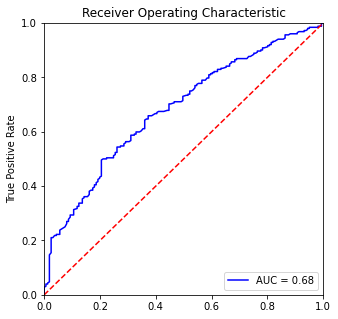

In [14]:
plt.figure(figsize=(5,5))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr,tpr,"b",
         label=f"AUC = {auc(fpr,tpr):0.2f}")
plt.legend(loc="lower right")
plt.plot([0,1],[0,1],"r--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.show()

In [15]:
myclassifier = LogisticRegression(solver="lbfgs")
acc = cross_val_score(estimator=myclassifier,
   X=X_train, y=y_train, scoring="accuracy", cv=5)
print(acc)
print(f"M={acc.mean():.2f}, SD={acc.std():.3f}")

[0.64652568 0.64048338 0.62727273 0.64242424 0.63636364]
M=0.64, SD=0.007


In [16]:
f1s = cross_val_score(estimator=myclassifier,
    X=X_train, y=y_train, 
    scoring=make_scorer(cohen_kappa_score), cv=5)
print(f1s)
print(f"M={f1s.mean():.2f}, SD={f1s.std():.3f}")


[0.1948816  0.19576536 0.15065913 0.1788275  0.16490932]
M=0.18, SD=0.017


In [17]:
myclassifier = RandomForestClassifier()
f1scorer = make_scorer(f1_score,pos_label="user")

grid = {
    "n_estimators" : [10, 50, 100, 200], 
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False],
    }
search = GridSearchCV(estimator=myclassifier,
                     param_grid=grid,
                     scoring=f1scorer,
                     cv=5)
search.fit(X_train, y_train)
print(f"Hyperparameters {search.best_params_} "
    "give the best performance:")
print(classification_report(y_test, 
    search.predict(X_test)))

Hyperparameters {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 200} give the best performance:
              precision    recall  f1-score   support

    non-user       0.44      0.37      0.40       161
        user       0.63      0.69      0.66       252

    accuracy                           0.57       413
   macro avg       0.54      0.53      0.53       413
weighted avg       0.56      0.57      0.56       413



In [21]:
myclassifier = SVC(gamma="scale")

grid = {
    "C" : [100, 1e4], 
    "kernel": ["linear","rbf", "poly"],
    "degree": [3,4]
}

search = GridSearchCV(estimator=myclassifier,
                      param_grid=grid,
                      scoring=f1scorer,
                      cv=5,
                      n_jobs=-1,  # use all cpus
                      verbose=10)
search.fit(X_train_scaled, y_train)
print(f"Hyperparameters {search.best_params_} "
    "give the best performance:")
print(classification_report(y_test, 
    search.predict(X_test_scaled)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Hyperparameters {'C': 100, 'degree': 3, 'kernel': 'poly'} give the best performance:
              precision    recall  f1-score   support

    non-user       0.58      0.04      0.08       161
        user       0.62      0.98      0.76       252

    accuracy                           0.62       413
   macro avg       0.60      0.51      0.42       413
weighted avg       0.60      0.62      0.49       413

